# Entrainement d'un Processus Gaussien "maison" avec tf.distribution.MVN

On veut vérifier que l'on sait entraîner proprement un processus Gaussien "à la main" en encodant une tf.distribution.MVN et en apprenant les paramètres du kernel par maximisation du likelihood

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

from gpvae_lib import GPNullMean, GPConstantMean, GPLinearMean
from gpvae_lib import CauchyKernel, GaussianKernel, RQKernel, MaternKernel

In [3]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB


In [5]:
N_POINTS = 1000
n_steps = N_POINTS
n_ahead = 50
n_series = 100

def generate_time_series(batch_size, n_steps, noise=0.05):
    """Utility function to generate time series data.

    Args:
        batch_size (int): number of time series to generate (btach size)
        n_steps (_type_): length of each time series
    """
    
    f1,f2,o1,o2 = np.random.rand(4, batch_size, 1)  # return 4 values for each time series
    time = np.linspace(0, 1, n_steps)  # time vector
    
    series = 0.4 * np.sin((time - o1) * (f1 * 5 + 10)) # first sine wave
    series += 0.2 * np.sin((time - o2) * (f2 * 20 + 20)) # second sine wave
    series += noise * (np.random.randn(batch_size, n_steps) - 0.5)  # add noise
    
    return series

In [6]:
s = generate_time_series(n_series, n_steps+n_ahead)

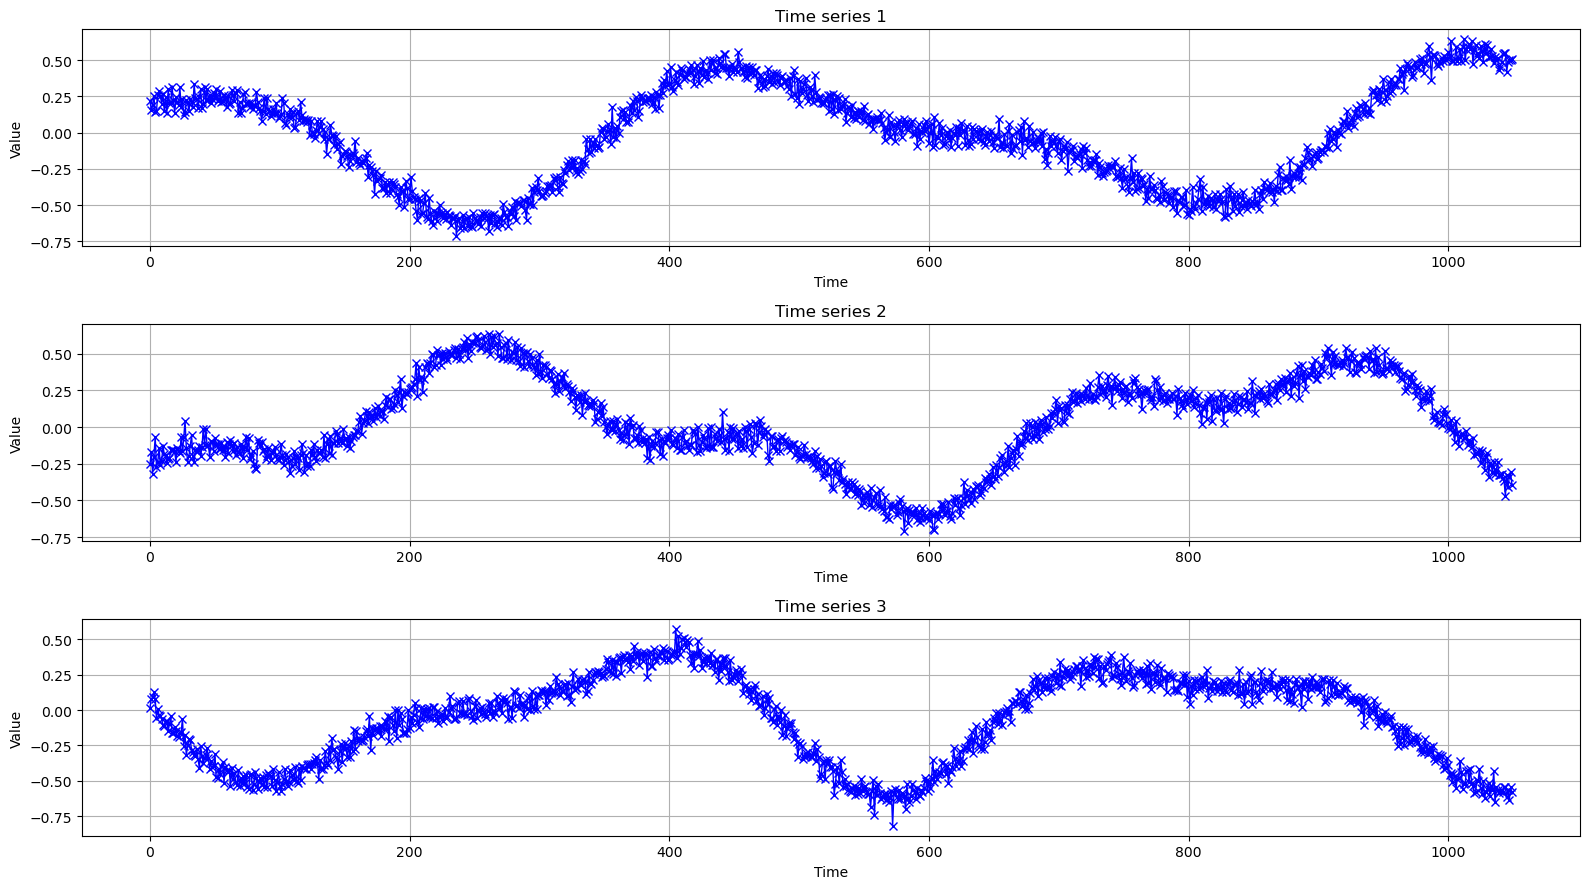

In [7]:
N = 3
fig, axs = plt.subplots(N, 1, figsize=(16, 3 * N))
for i in range(N):
    axs[i].plot(s[i], color='blue', marker="x", linewidth=1)
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [8]:
cutoff = int(0.8 * n_series)

X_train, y_train = s[:cutoff,:n_steps], s[:cutoff,n_steps:]
X_valid, y_valid = s[cutoff:,:n_steps], s[cutoff:,n_steps:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_train shape: (80, 1000)
y_train shape: (80, 50)
X_valid shape: (20, 1000)
y_valid shape: (20, 50)


In [9]:
# form datasets, dataloaders, etc

BATCH_SIZE = 16  # 8192 ok sur RTX3080 et 150 time steps

from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).to(device)
        self.y = torch.tensor(y).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## On apprend le PG sur une time serie

In [48]:
# mean = GPNullMean() 
# mean = GPConstantMean(constant_init=1.0)
mean = GPLinearMean(slope_init=0.0, intercept_init=0.0)

kernel = GaussianKernel(lengthscale=1e+0, sigma=1e+0)
# kernel = CauchyKernel(lengthscale=1e+0, sigma=1e+0)
# kernel = RQKernel(alpha=1e+0, beta=1e+0, sigma=1e+0, epsilon=1.0)
# kernel = MaternKernel(lengthscale=1e+0, sigma=1e+0, nu=0.5)
# kernel = MaternKernel(lengthscale=1e+0, sigma=1e+0, nu=1.5)
# kernel = MaternKernel(lengthscale=1e+0, sigma=1e+0, nu=2.5)

In [49]:
print(mean)
print(f"Mean function parameters:")
for name, param in mean.named_parameters():
    print(f"{name} : {param}")

print()
print(kernel)
print(f"Kernel parameters:")
for name, param in kernel.named_parameters():
    print(f"{name} : {param}")

GPLinearMean
Mean function parameters:
slope : Parameter containing:
tensor(0., requires_grad=True)
intercept : Parameter containing:
tensor(0., requires_grad=True)

GaussianKernel(lengthscale=1.000e+00, variance (sigma**2)=1.000e+00, sigma=1.000e+00, epsilon=1.000e-03)
Kernel parameters:
lengthscale : Parameter containing:
tensor(1., requires_grad=True)
sigma : Parameter containing:
tensor(1., requires_grad=True)


In [40]:
# fonction simple
# a = -2.0
# b = +3.0
# times = torch.linspace(0, 1, n_steps).unsqueeze(0).to(device)  # (1, n_steps)
# targets = times * torch.sin(8 * 2 * torch.pi * times).to(device)  + a * times + b # (1, n_steps)

# sample sinusoïdes compliquées
# id = np.random.randint(0, cutoff)
# times = torch.linspace(0, 1, n_steps).unsqueeze(0).to(device)  # (1, n_steps)
# targets = torch.tensor(X_train[id,:]).unsqueeze(0).to(device)  # (1, n_steps)

# Brownian motion
times = torch.linspace(0, 1, n_steps).unsqueeze(0).to(device)  # (1, n_steps)
delta_t = torch.tensor(1.0 / n_steps)
sigma = torch.tensor(0.1)
targets = torch.cumsum(sigma * torch.sqrt(delta_t) * torch.randn(1, n_steps), dim=1).to(device)  # (1, n_steps)

In [41]:
N_SAMPLES = np.random.randint(5, 30)  # random number of samples between 1 and 30
idx = np.random.choice(N_POINTS, N_SAMPLES, replace=False)
train_times = times[:, idx]  # (1, N_SAMPLES)
train_targets = targets[:, idx]  # (1, N_SAMPLES)

print(f"Using {N_SAMPLES} samples for training")

Using 20 samples for training


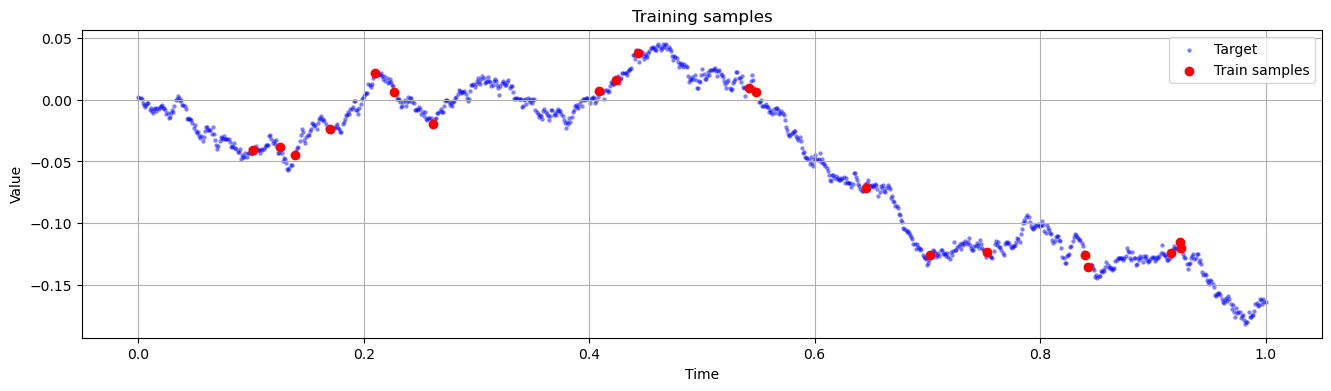

In [50]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.scatter(times[0].cpu().numpy(), targets[0].cpu().numpy(), color='blue', marker=".", alpha=0.5, linewidth=0.05, label="Target")
ax.scatter(train_times[0].cpu().numpy(), train_targets[0].cpu().numpy(), color='red', marker="o", linewidth=1, label="Train samples")
ax.set_title("Training samples")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.show()

In [51]:
# learnable parameters : kernel parameters only
optimizer = torch.optim.Adam(
    list(kernel.parameters()) + list(mean.parameters()),
    lr=1e-3
    )

In [52]:
# Train the GP model to get the kernel parameters

N_EPOCHS = int(1e+5)  # number of epochs for training
TOLERANCE = 1e-8  # tolerance for early stopping

kernel.train()  # set the kernel in training mode
mean.train()  # set the mean in training mode

losses = []  # to store the losses

# dictionnary to store the parameters
mean_params = {}  # to store mean parameters if any
for name, param in mean.named_parameters():
    mean_params[name] = []
    
kernel_params = {}  # to store kernel parameters if any
for name, param in kernel.named_parameters():
    kernel_params[name] = []

prev_loss = float('inf')  # initialize previous loss to infinity

for epoch in range(N_EPOCHS):  # number of epochs

    # compute the mean of the posterior GP
    loc = mean(train_times)  # (1, N)

    # compute the covariance matrix of the posterior GP
    covar, L = kernel(train_times, train_times)  # (1, N, N)

    # check
    assert L is not None, "Cholesky decomposition failed, L should not be None."

    # instantiate the GP prior with the lower traingular matrix L from Cholesky decomposition
    gp = torch.distributions.MultivariateNormal(loc, scale_tril=L)

    # compute the log likelihood of the GP prior
    log_likelihood = gp.log_prob(train_targets)  # (1,)

    # get the loss
    loss = -log_likelihood.mean()  # mean over the batch
    
    # backpropagation
    optimizer.zero_grad()  # zero the gradients
    loss.backward()  # backpropagation
    optimizer.step()  # update the parameters
    
    # report out metrics
    losses.append(loss.item())
    
    # record parameters
    for name, param in mean.named_parameters():
        mean_params[name].append(param.item())
    for name, param in kernel.named_parameters():
        kernel_params[name].append(param.item())
    
    print(f"Epoch {epoch+1:>5}/{N_EPOCHS:>5}, Loss: {loss.item():.4f}", end="\r")
    
    # should we stop
    if epoch > 0 and abs(loss.item() - prev_loss) < TOLERANCE:
        print(f"\nEarly stopping at epoch {epoch+1} with loss {loss.item():.4f}")
        break
    else:
        prev_loss = loss.item()

Epoch   887/100000, Loss: -41.4684
Early stopping at epoch 887 with loss -41.4684


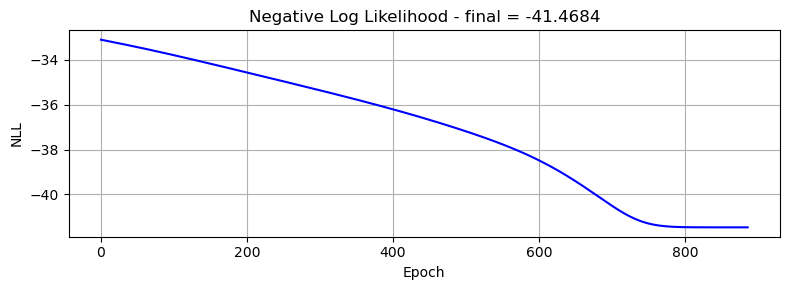

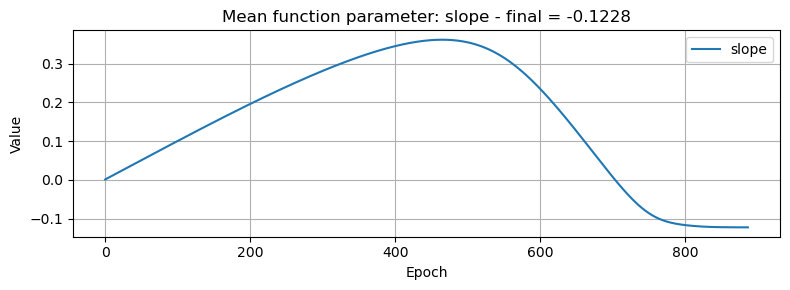

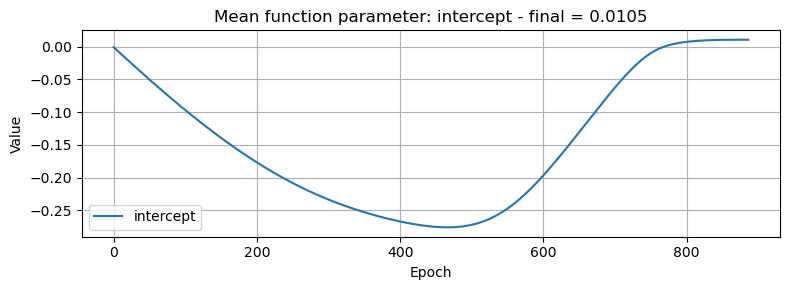

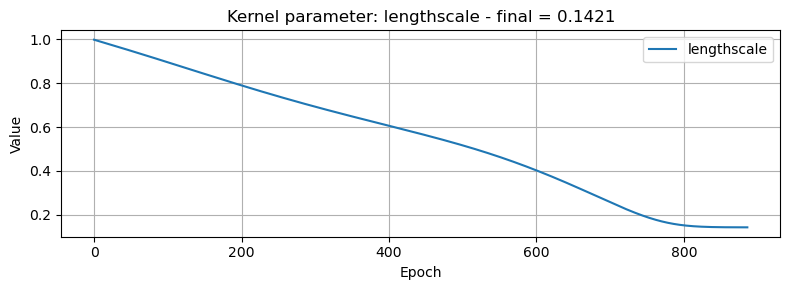

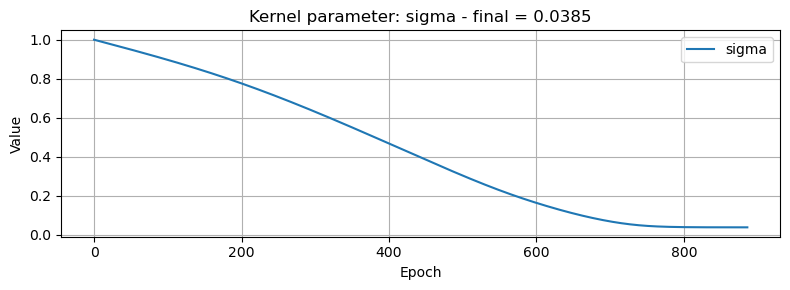

In [53]:
WIDTH = 8
HEIGHT = 3

# Likelihood plot
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))        
ax.plot(losses, color='blue')
ax.set_title(f"Negative Log Likelihood - final = {losses[-1]:.4f}")
ax.set_xlabel("Epoch")
ax.set_ylabel("NLL")
ax.grid(True)
plt.tight_layout()
plt.show()

# plot mean function parameters
for name,_ in mean.named_parameters():
    fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))     
    ax.plot(mean_params[name], label=name)
    ax.set_title(f"Mean function parameter: {name} - final = {mean_params[name][-1]:.4f}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Value")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    
# plot kernel parameters
for name,_ in kernel.named_parameters():
    fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))      
    ax.plot(kernel_params[name], label=name)
    ax.set_title(f"Kernel parameter: {name} - final = {kernel_params[name][-1]:.4f}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Value")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

In [54]:
# compute predictions
N_POINTS = 1000  # number of points to predict
TIMES = 1.25  # nombre d'intervalles au-delà des données d'entraînement

all_times = torch.linspace(0, 1 * TIMES, N_POINTS).to(device).unsqueeze(0)  # shape (1, n_steps)

k_1_1, _ = kernel(train_times, train_times)  # (1, N, N)
k_2_1, _ = kernel(all_times, train_times)  # (1, N_POINTS, N)
k_1_2 = k_2_1.transpose(-1, -2)  # (1, N, N_POINTS)
k_2_2, _ = kernel(all_times, all_times)  # (1, N_POINTS, N_POINTS)

# posterior mean dans le cas général, cad GPMean a priori non nul
posterior_mean =  mean(all_times).unsqueeze(-1) + k_2_1 @ (torch.linalg.inv(k_1_1) @ (train_targets-mean(train_times)).unsqueeze(-1))  # (1, N_POINTS)
posterior_cov = k_2_2 - k_2_1 @ torch.linalg.solve(k_1_1, k_1_2)  # (1, N_POINTS, N_POINTS)

# instantiate the GP posterior with the posterior mean and covariance
gp_posterior = torch.distributions.MultivariateNormal(posterior_mean.squeeze(-1), scale_tril=torch.linalg.cholesky(posterior_cov))

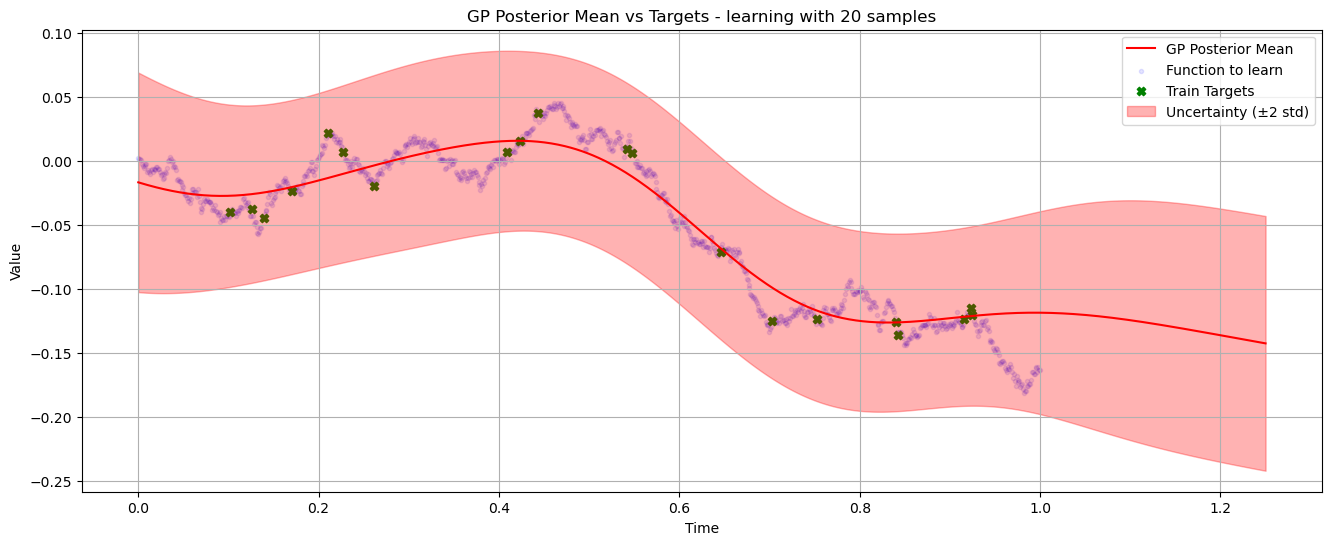

In [55]:
# sample from the posterior and display the predictions

# preds = gp_posterior.sample()  # (1, N_POINTS)

fig, axs = plt.subplots(1, 1, figsize=(16, 6))

axs.plot(all_times.cpu().numpy().squeeze(), posterior_mean.squeeze().detach().cpu().numpy(), color='red', label='GP Posterior Mean')
axs.scatter(times.cpu().numpy().squeeze(), targets.cpu().numpy().squeeze(), color='blue', alpha=0.10, marker='.', label='Function to learn')
axs.scatter(train_times.cpu().numpy().squeeze(), train_targets.cpu().numpy().squeeze(), color='green', marker='X', label='Train Targets')
axs.fill_between(all_times.cpu().numpy().squeeze(),
                 (posterior_mean.squeeze().detach().cpu().numpy() - 2 * np.sqrt(torch.diagonal(posterior_cov, dim1=-2, dim2=-1).squeeze().detach().cpu().numpy())),
                 (posterior_mean.squeeze().detach().cpu().numpy() + 2 * np.sqrt(torch.diagonal(posterior_cov, dim1=-2, dim2=-1).squeeze().detach().cpu().numpy())),
                 color='red', alpha=0.3, label='Uncertainty (±2 std)')
plt.legend()
plt.title(f"GP Posterior Mean vs Targets - learning with {N_SAMPLES} samples")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()